In [75]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [76]:
data_dir = r'C:\Users\Administrator\Desktop\DL_study\MEDICAL-DATASET-001\Segmentation'
annotation_path = os.path.join(data_dir,'train.csv')
data_df = pd.read_csv(annotation_path)

In [77]:
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [78]:
data_df['id'] = data_df['ImageId'].apply(lambda x: x.split('_')[0])

In [79]:
client_id = data_df['id'].unique()

In [80]:
index = 0
client_data = data_df[['ImageId', 'MaskId']][client_id[index] == data_df['id']]

Text(0.5, 1.0, 'masked')

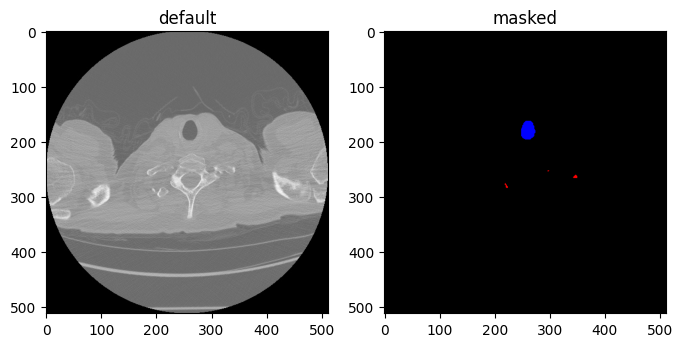

In [81]:
sub_index = 0
threshold = 240
img_name, mask_name = client_data.iloc[sub_index, :]
img_path = os.path.join(data_dir, 'images', img_name)
mask_path = os.path.join(data_dir, 'masks', mask_name)
img_array = cv2.imread(img_path)
mask_array = cv2.imread(mask_path)

mask_array[mask_array < threshold] = 0
mask_array[mask_array >= threshold] = 255

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.title('default')
plt.imshow(img_array)
plt.subplot(122)
plt.imshow(mask_array)
plt.title('masked')

In [82]:
img_array.shape

(512, 512, 3)

In [83]:
def get_client_data(data_df, index):
    client_id_list = np.unique(data_df['id'])
    client_id = client_id_list[index]
    client_data = data_df[['ImageId', 'MaskId']][client_id == data_df['id']]
    img_file_list = list(client_data['ImageId'])
    mask_file_list = list(client_data['MaskId'])
    return client_id, img_file_list, mask_file_list

In [84]:
region = ['background', 'trachea', 'heart', 'lung']
colors = ((0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [85]:
idx = 20
client_0 , imgs_0, mask_0 = get_client_data(data_df, index)

canvas = np.zeros(shape=(512, 2 * 512 + 50, 3), dtype=np.uint8)
for i in range(len(imgs_0)):
    image = cv2.imread(os.path.join(data_dir, 'images', imgs_0[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, 'masks', mask_0[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    threshold = 240
    mask[mask >= threshold] = 255
    mask[mask < threshold] = 0

    canvas[:, 0:512, :] = image
    canvas[:, 512+50: 2*512+50, :] = mask

    text_buff = 410
    for j in range(1, len(region)):
        cv2.putText(canvas, f'{region[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40

    cv2.imshow('CT frames', canvas)
    key = cv2.waitKey(120)
    if key == 27:
        break
cv2.destroyAllWindows()

In [86]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [87]:
class CTDataset(Dataset):
    def __init__(self, data_dir, phase, transformer=None):
        self.imgs_dir = os.path.join(data_dir, 'images')
        self.masks_dir = os.path.join(data_dir, 'masks')
        self.phase = phase
        self.imgs_file_list = [filename for filename in os.listdir(self.imgs_dir) if filename.endswith('jpg')]
        self.masks_file_list = [filename for filename in os.listdir(self.masks_dir) if filename.endswith('jpg')]
        
        assert len(self.imgs_file_list) == len(self.masks_file_list)

        self.transformer = transformer

    def __len__(self, ):
        return len(self.imgs_file_list)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.imgs_dir, self.imgs_file_list[index]))
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks_file_list[index]))
        mask = cv2.resize(mask, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask/ 255.

        mask_height, mask_width, _ = mask.shape
        background = np.ones(shape=(mask_height, mask_width))
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 0] = 0
        background[mask[..., 2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, axis=1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)

        if self.transformer:
            image = self.transformer(image)
        
        target = torch.from_numpy(mask).long()
        return image, target
        

In [92]:
train_dir = r'C:\Users\Administrator\Desktop\DL_study\MEDICAL-DATASET-001\Segmentation\train'
val_dir = r'C:\Users\Administrator\Desktop\DL_study\MEDICAL-DATASET-001\Segmentation\val'

In [93]:
train_dataset = CTDataset(train_dir, None, None)

In [95]:
val_dataset = CTDataset(val_dir, None, None)

In [96]:
train_dataset[0]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 224